In [5]:
import pandas as pd
import numpy as np
import math
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

MODELS_CACHE = {}

def main(year, sim_count):
    
    data = pd.read_csv("../../data/data_official.csv")
    
    if year not in MODELS_CACHE:
        try:
            with open(f'../RFmodels/rf_model_{year}.pkl', 'rb') as f:
                MODELS_CACHE[year] = pickle.load(f)
        except FileNotFoundError:
            raise ValueError(f"Model for year {year} not found. Please train it first.")
            
    model = MODELS_CACHE[year]
    
    data['Sim_Wins'] = [-1 for _ in range(len(data))]
    data['R68_win%'] = [1.0 for _ in range(len(data))]
    data['R64_win%'] = [0.0 for _ in range(len(data))]
    data['R32_win%'] = [0.0 for _ in range(len(data))]
    data['S16_win%'] = [0.0 for _ in range(len(data))]
    data['E8_win%'] = [0.0 for _ in range(len(data))]
    data['F4_win%'] = [0.0 for _ in range(len(data))]
    data['CG_win%'] = [0.0 for _ in range(len(data))]
    data['R68_opp'] = ["N/A" for _ in range(len(data))]
    data['R64_opp'] = ["N/A" for _ in range(len(data))]
    data['R32_opp'] = ["N/A" for _ in range(len(data))]
    data['S16_opp'] = ["N/A" for _ in range(len(data))]
    data['E8_opp'] = ["N/A" for _ in range(len(data))]
    data['F4_opp'] = ["N/A" for _ in range(len(data))]
    data['CG_opp'] = ["N/A" for _ in range(len(data))]
    
    i = 0
    
    sims = []
    scores = []
        
    while i < sim_count:
        
        sim_df = simulation(year, i, data, model)
        
        score = 0

        score = score + (10 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 0) & (sim_df["Sim_Wins"] > 0)])))
        score = score + (20 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 1) & (sim_df["Sim_Wins"] > 1)])))
        score = score + (40 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 2) & (sim_df["Sim_Wins"] > 2)])))
        score = score + (80 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 3) & (sim_df["Sim_Wins"] > 3)])))
        score = score + (160 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 4) & (sim_df["Sim_Wins"] > 4)])))
        score = score + (320 * (len(sim_df[(sim_df["YEAR"] == year) & (sim_df["Wins"] > 5) & (sim_df["Sim_Wins"] > 5)])))
        
        sims.append(sim_df)
        scores.append(score)
        i = i+1
                
    full_df = pd.concat(sims, axis=0).reset_index(drop=True)
    
    final_df = calc_outcome(full_df)
    
    final_df1 = final_df[['sim_num', 'QUAD ID', 'TEAM', 'SEED', 'Wins', 'Sim_Wins', 'R68_win%', 'R68_opp', 'R64_win%', 'R64_opp', 'R32_win%', 'R32_opp', 'S16_win%', 'S16_opp', 'E8_win%', 'E8_opp', 'F4_win%', 'F4_opp', 'CG_win%', 'CG_opp', 'Outcome_%']]
        
    return final_df1, scores

def simulation(year, sim_num, data, model):
    
    data = data.copy()
    
    data['sim_num'] = sim_num + 1
    
    df1 = region_simulation(data, year, 1, model)
    df1n = df1[df1["QUAD ID"] == 1]
    df2 = region_simulation(data, year, 2, model)
    df2n = df2[df2["QUAD ID"] == 2]
    df3 = region_simulation(data, year, 3, model)
    df3n = df3[df3["QUAD ID"] == 3]
    df4 = region_simulation(data, year, 4, model)
    df4n = df4[df4["QUAD ID"] == 4]
    
    df = pd.concat([df1n, df2n, df3n, df4n])
        
    df = final4(df, year, model)
    
    df = championship(df, year, model)
    
    df_year = df[df["YEAR"] == year]
    dfn = df_year[['sim_num', 'YEAR', 'QUAD ID', 'TEAM', 'SEED', 'Wins', 'Sim_Wins', 'R68_win%', 'R68_opp', 'R64_win%', 'R64_opp', 'R32_win%', 'R32_opp', 'S16_win%', 'S16_opp', 'E8_win%', 'E8_opp', 'F4_win%', 'F4_opp', 'CG_win%', 'CG_opp']]
                            
    return dfn

def region_simulation(data, year, quad, model):
    
    seeds = list(range(1,17))

    ###########################################################################
    # FIRST FOUR
    
    for seed in seeds:
    
        if data[(data["SEED"] == seed) & (data["YEAR"] == year) & (data["QUAD ID"] == quad)].shape[0] > 1:
            
            data = same_seed(data, year, quad, seed, model)
    ##########################################################################
    ##########################################################################
    # FIRST ROUND (R64)
        
    data = round64(data, year, quad, model)
    
    ##########################################################################
    ##########################################################################
    # SECOND ROUND (R32)
    
    data = round32(data, year, quad, model)
    
    ##########################################################################
    ##########################################################################
    # SWEET 16
    
    data = sweet16(data, year, quad, model)
    
    ##########################################################################
    ##########################################################################
    # ELITE 8
    
    data = elite8(data, year, quad, model)
    
    return data

def same_seed(data, year, quad, seed, model):
    
    subdf = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad) & (data["SEED"] == seed)].copy()
    team0 = subdf.head(1)
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf.tail(1)
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    
    perc = find_percentages(data, team0name, team1name, year, model)
    
    data.loc[team0index, "R68_win%"] = perc
    data.loc[team1index, "R68_win%"] = 1-perc
    data.loc[team0index, "R68_opp"] = team1name
    data.loc[team1index, "R68_opp"] = team0name
    
    winner = weighted_coin_flip(perc)

    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 0

    else:
        data.loc[team0index, "Sim_Wins"] = 0
        
    return data

def round64(data, year, quad, model):
    
    subdf = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad) & (data["Sim_Wins"] == -1)]
    
    seeds1 = [1,2,3,4,5,6,7,8]
    seeds2 = [16,15,14,13,12,11,10,9]
    
    for i in range(0,8):
        
        rdf = subdf[(subdf["SEED"] == seeds1[i]) | (subdf["SEED"] == seeds2[i])]
        team0 = rdf.head(1)
        team0name = str(team0["TEAM"].iloc[0])
        team0index = team0["TEAM"].index
        team1 = rdf.tail(1)
        team1name = str(team1["TEAM"].iloc[0])
        team1index = team1["TEAM"].index
                
        perc = find_percentages(data, team0name, team1name, year, model)
        
        data.loc[team0index, "R64_win%"] = perc
        data.loc[team1index, "R64_win%"] = 1-perc
        data.loc[team0index, "R64_opp"] = team1name
        data.loc[team1index, "R64_opp"] = team0name

        winner = weighted_coin_flip(perc)
        
        if winner == 1:
            data.loc[team1index, "Sim_Wins"] = 0

        else:
            data.loc[team0index, "Sim_Wins"] = 0

    return data

def round32(data, year, quad, model):
    
    subdf = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad) & (data["Sim_Wins"] == -1)]
    
    team0 = subdf[(subdf["SEED"] == 1) | (subdf["SEED"] == 16)]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf[(subdf["SEED"] == 8) | (subdf["SEED"] == 9)]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "R32_win%"] = perc
    data.loc[team1index, "R32_win%"] = 1-perc
    data.loc[team0index, "R32_opp"] = team1name
    data.loc[team1index, "R32_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 1
    else:
        data.loc[team0index, "Sim_Wins"] = 1
    
    team0 = subdf[(subdf["SEED"] == 5) | (subdf["SEED"] == 12)]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf[(subdf["SEED"] == 4) | (subdf["SEED"] == 13)]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "R32_win%"] = perc
    data.loc[team1index, "R32_win%"] = 1-perc
    data.loc[team0index, "R32_opp"] = team1name
    data.loc[team1index, "R32_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 1
    else:
        data.loc[team0index, "Sim_Wins"] = 1
    
    team0 = subdf[(subdf["SEED"] == 6) | (subdf["SEED"] == 11)]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf[(subdf["SEED"] == 3) | (subdf["SEED"] == 14)]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "R32_win%"] = perc
    data.loc[team1index, "R32_win%"] = 1-perc
    data.loc[team0index, "R32_opp"] = team1name
    data.loc[team1index, "R32_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 1
    else:
        data.loc[team0index, "Sim_Wins"] = 1
    
    team0 = subdf[(subdf["SEED"] == 7) | (subdf["SEED"] == 10)]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf[(subdf["SEED"] == 2) | (subdf["SEED"] == 15)]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "R32_win%"] = perc
    data.loc[team1index, "R32_win%"] = 1-perc
    data.loc[team0index, "R32_opp"] = team1name
    data.loc[team1index, "R32_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 1
    else:
        data.loc[team0index, "Sim_Wins"] = 1
        
    return data

def sweet16(data, year, quad, model):
    
    subdf = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad) & (data["Sim_Wins"] == -1)]
    
    options1 = [1,8,9,16]
    for i in options1:
        if not subdf[subdf["SEED"] == i].empty:
            team0 = subdf[subdf["SEED"] == i]
            break
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    options2 = [4,5,12,13]
    for i in options2:
        if not subdf[subdf["SEED"] == i].empty:
            team1 = subdf[subdf["SEED"] == i]
            break
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "S16_win%"] = perc
    data.loc[team1index, "S16_win%"] = 1-perc
    data.loc[team0index, "S16_opp"] = team1name
    data.loc[team1index, "S16_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 2
    else:
        data.loc[team0index, "Sim_Wins"] = 2

    options3 = [3,6,11,14]
    for i in options3:
        if not subdf[subdf["SEED"] == i].empty:
            team0 = subdf[subdf["SEED"] == i]
            break
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    options4 = [2,7,10,15]
    for i in options4:
        if not subdf[subdf["SEED"] == i].empty:
            team1 = subdf[subdf["SEED"] == i]
            break
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "S16_win%"] = perc
    data.loc[team1index, "S16_win%"] = 1-perc
    data.loc[team0index, "S16_opp"] = team1name
    data.loc[team1index, "S16_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 2
    else:
        data.loc[team0index, "Sim_Wins"] = 2  
    
    return data

def elite8(data, year, quad, model):
    
    subdf = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad) & (data["Sim_Wins"] == -1)]
    
    options1 = [1,4,5,8,9,12,13,16]
    for i in options1:
        if not subdf[subdf["SEED"] == i].empty:
            team0 = subdf[subdf["SEED"] == i]
            break
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    
    options2 = [2,3,6,7,10,11,14,15]
    for i in options2:
        if not subdf[subdf["SEED"] == i].empty:
            team1 = subdf[subdf["SEED"] == i]
            break
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "E8_win%"] = perc
    data.loc[team1index, "E8_win%"] = 1-perc
    data.loc[team0index, "E8_opp"] = team1name
    data.loc[team1index, "E8_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 3
    else:
        data.loc[team0index, "Sim_Wins"] = 3
        
    return data

def final4(data, year, model):
    
    subdf = data[(data["YEAR"] == year) & (data["Sim_Wins"] == -1)]
    
    team0 = subdf[subdf["QUAD ID"] == 1]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
        
    team1 = subdf[subdf["QUAD ID"] == 2]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "F4_win%"] = perc
    data.loc[team1index, "F4_win%"] = 1-perc
    data.loc[team0index, "F4_opp"] = team1name
    data.loc[team1index, "F4_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 4
    else:
        data.loc[team0index, "Sim_Wins"] = 4
        
    team0 = subdf[subdf["QUAD ID"] == 3]
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
        
    team1 = subdf[subdf["QUAD ID"] == 4]
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
        
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "F4_win%"] = perc
    data.loc[team1index, "F4_win%"] = 1-perc
    data.loc[team0index, "F4_opp"] = team1name
    data.loc[team1index, "F4_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 4
    else:
        data.loc[team0index, "Sim_Wins"] = 4    
    
    return data

def championship(data, year, model):
    
    subdf = data[(data["YEAR"] == year) & (data["Sim_Wins"] == -1)]
    
    team0 = subdf.head(1)
    team0name = str(team0["TEAM"].iloc[0])
    team0index = team0["TEAM"].index
    team1 = subdf.tail(1)
    team1name = str(team1["TEAM"].iloc[0])
    team1index = team1["TEAM"].index
    
    perc = find_percentages(data, team0name, team1name, year, model)
    data.loc[team0index, "CG_win%"] = perc
    data.loc[team1index, "CG_win%"] = 1-perc
    data.loc[team0index, "CG_opp"] = team1name
    data.loc[team1index, "CG_opp"] = team0name
    winner = weighted_coin_flip(perc)
    if winner == 1:
        data.loc[team1index, "Sim_Wins"] = 5
        data.loc[team0index, "Sim_Wins"] = 6
    else:
        data.loc[team0index, "Sim_Wins"] = 5
        data.loc[team1index, "Sim_Wins"] = 6    
    
    return data

def game_style(df, team0, team1, year):
    
    cols = ['KADJ T',
       'KADJ O', 'KADJ D', 'EFG%', 'EFG%D', 'FTR', 'FTRD', 'TOV%',
       'TOV%D', 'OREB%', 'DREB%', '2PT%', '2PT%D', '3PT%', '3PT%D', 'AST%',
       '2PTR', '3PTR', '2PTRD', '3PTRD', 'EFF HGT', 'EXP', 'FT%',
       'ELITE SOS']
    
    t0 = df[(df["TEAM"] == team0) & (df["YEAR"] == year)].reset_index(drop=True)
    t1 = df[(df["TEAM"] == team1) & (df["YEAR"] == year)].reset_index(drop=True)
    
    game = pd.DataFrame()
    
    for col in cols:
        game[col] = t0[col] - t1[col]
    game.insert(0, "YEAR", year)
    game.insert(1, "Team0", t0["TEAM"])
    game.insert(2, "Team1", t1["TEAM"])
    
    return game

def find_percentages(df, team0, team1, year, model):
    
    features = ['KADJ T', 'KADJ O', 'KADJ D', 'EFG%', 'EFG%D', 'FTR', 'FTRD', 
                'TOV%', 'TOV%D', 'OREB%', 'DREB%', '2PT%', '2PT%D', '3PT%', 
                '3PT%D', 'AST%', '2PTR', '3PTR', '2PTRD', '3PTRD', 'EFF HGT', 
                'EXP', 'FT%', 'ELITE SOS']
    
    game_01 = game_style(df, team0, team1, year)
    game_10 = game_style(df, team1, team0, year)
    
    X_test_01 = game_01[features].values
    X_test_10 = game_10[features].values
    
    probs_01 = model.predict_proba(X_test_01)[0]
    probs_10 = model.predict_proba(X_test_10)[0]
    
    team0_win_prob = (probs_01[0] + probs_10[1]) / 2
    team1_win_prob = (probs_01[1] + probs_10[0]) / 2
    
    return team0_win_prob

def weighted_coin_flip(perc1):
    
    num = random.random()
    
    if num < perc1:
        return 1
    
    else:
        return 2
    
def calc_outcome(df):
    
    df['Outcome_%'] = [0 for _ in range(len(df))]
    
    df.loc[df['Sim_Wins'] == 6, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * df['R32_win%'] * df['S16_win%'] * df['E8_win%'] * df['F4_win%'] * df['CG_win%']
    df.loc[df['Sim_Wins'] == 5, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * df['R32_win%'] * df['S16_win%'] * df['E8_win%'] * df['F4_win%'] * (1-df['CG_win%'])
    df.loc[df['Sim_Wins'] == 4, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * df['R32_win%'] * df['S16_win%'] * df['E8_win%'] * (1-df['F4_win%'])
    df.loc[df['Sim_Wins'] == 3, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * df['R32_win%'] * df['S16_win%'] * (1-df['E8_win%'])
    df.loc[df['Sim_Wins'] == 2, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * df['R32_win%'] * (1-df['S16_win%'])
    df.loc[df['Sim_Wins'] == 1, 'Outcome_%'] = df['R68_win%'] * df['R64_win%'] * (1-df['R32_win%'])
    df.loc[(df['Sim_Wins'] == 0) & (df['R64_win%'] != 0), 'Outcome_%'] = df['R68_win%'] * (1-df['R64_win%'])
    df.loc[(df['Sim_Wins'] == 0) & (df['R64_win%'] == 0), 'Outcome_%'] = (1-df['R68_win%'])
    
    df['R68_win%'] = df['R68_win%'].mul(100).round(3)
    df['R64_win%'] = df['R64_win%'].mul(100).round(3)
    df['R32_win%'] = df['R32_win%'].mul(100).round(3)
    df['S16_win%'] = df['S16_win%'].mul(100).round(3)
    df['E8_win%'] = df['E8_win%'].mul(100).round(3)
    df['F4_win%'] = df['F4_win%'].mul(100).round(3)
    df['CG_win%'] = df['CG_win%'].mul(100).round(3)
    df['Outcome_%'] = df['Outcome_%'].mul(100).round(3)
        
    return df

In [6]:
df, scores = main(2025, 25)

In [22]:
import numpy as np

top_5_indices = np.argsort(scores)[-5:][::-1]  
top_5 = [(i+1, scores[i]) for i in top_5_indices] 

bottom_5_indices = np.argsort(scores)[:5]  
bottom_5 = [(i+1, scores[i]) for i in bottom_5_indices]

avg_score = np.mean(scores)

print("=" * 40)
print("TOP 5 SCORES")
print("=" * 40)
for sim_num, score in top_5:
    print(f"Sim #{sim_num}: {score}")

print("\n" + "=" * 40)
print("BOTTOM 5 SCORES")
print("=" * 40)
for sim_num, score in bottom_5:
    print(f"Sim #{sim_num}: {score}")

print("\n" + "=" * 40)
print(f"AVERAGE SCORE: {avg_score:.2f}")
print("=" * 40)

TOP 5 SCORES
Sim #14: 1370
Sim #9: 1330
Sim #3: 1160
Sim #12: 1120
Sim #11: 1110

BOTTOM 5 SCORES
Sim #23: 400
Sim #4: 520
Sim #19: 550
Sim #1: 590
Sim #22: 630

AVERAGE SCORE: 844.00


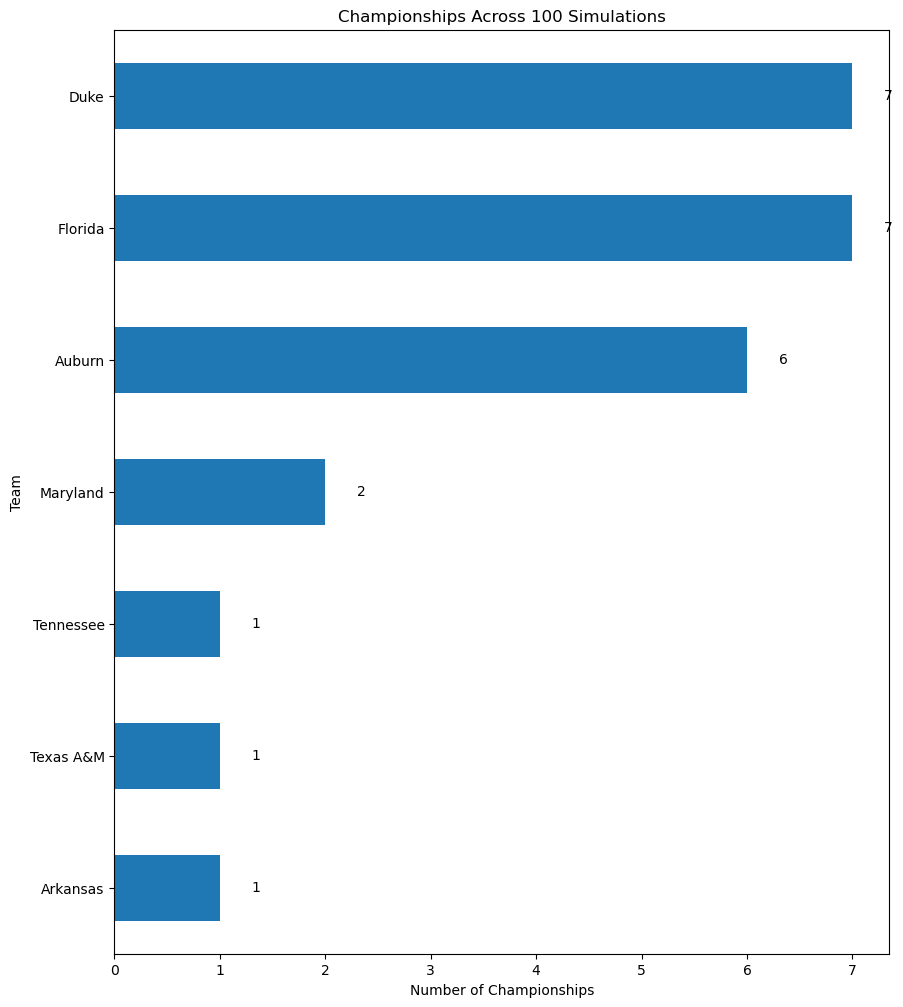

In [18]:
import matplotlib.pyplot as plt

champ_counts = df.loc[df['Sim_Wins'] == 6, 'TEAM'].value_counts()

ax = champ_counts[::-1].plot(kind='barh', figsize=(10,12))

plt.title("Championships Across 100 Simulations")
plt.ylabel("Team")
plt.xlabel("Number of Championships")
plt.yticks(rotation=0)

for i, v in enumerate(champ_counts[::-1]):
    ax.text(v + 0.3, i, str(v), va='center')

plt.show()

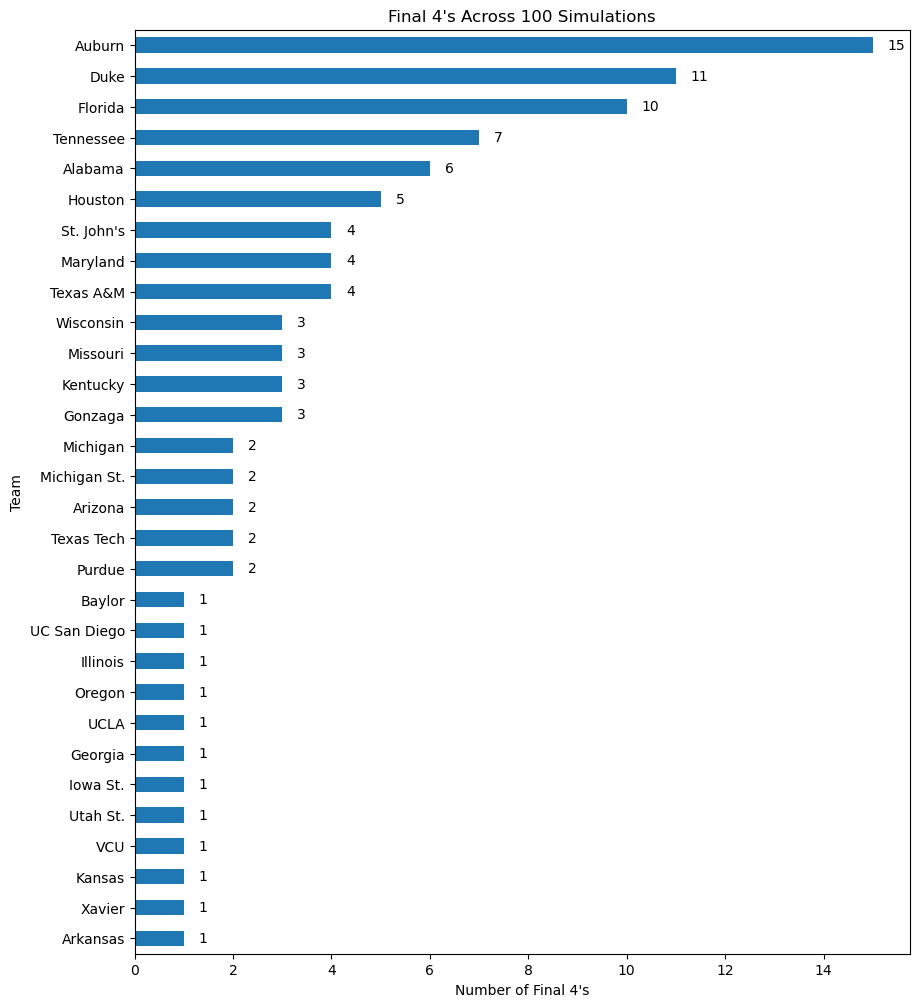

In [11]:
import matplotlib.pyplot as plt

champ_counts = df.loc[df['Sim_Wins'] >= 4, 'TEAM'].value_counts()

ax = champ_counts[::-1].plot(kind='barh', figsize=(10,12))

plt.title("Final 4's Across 100 Simulations")
plt.ylabel("Team")
plt.xlabel("Number of Final 4's")
plt.yticks(rotation=0)

for i, v in enumerate(champ_counts[::-1]):
    ax.text(v + 0.3, i, str(v), va='center')

plt.show()

In [21]:
pd.set_option('display.max_columns', None)
df.sort_values("Outcome_%", ascending=True).head(25)

,sim_num,QUAD ID,TEAM,SEED,Wins,Sim_Wins,R68_win%,R68_opp,R64_win%,R64_opp,R32_win%,R32_opp,S16_win%,S16_opp,E8_win%,E8_opp,F4_win%,F4_opp,CG_win%,CG_opp,Outcome_%
1666,25,3,Arkansas,10,2,6,100.000,N/A,28.279,Kansas,32.326,St. John's,27.704,Texas Tech,17.372,Florida,34.620,Michigan,17.672,Houston,0.027
152,3,1,Xavier,11,0,4,38.891,Texas,21.022,Illinois,22.502,Kentucky,13.812,Tennessee,13.393,Houston,15.844,Arizona,0.000,N/A,0.029
912,14,2,Oregon,5,1,5,100.000,N/A,75.215,Liberty,25.380,Arizona,14.410,Duke,43.002,BYU,16.587,Houston,15.573,Florida,0.166
490,8,1,Utah St.,10,0,4,100.000,N/A,34.350,UCLA,23.223,Tennessee,18.834,Illinois,18.216,Houston,12.275,Duke,0.000,N/A,0.240
13,1,1,UCLA,7,1,5,100.000,N/A,65.650,Utah St.,20.728,Tennessee,38.300,Illinois,44.859,Clemson,16.754,Duke,18.561,Auburn,0.319
1426,21,4,UC San Diego,12,0,4,100.000,N/A,26.466,Michigan,64.566,Yale,14.761,Auburn,20.536,Iowa St.,16.838,Maryland,0.000,N/A,0.431
1492,22,4,San Diego St.,11,0,3,40.311,North Carolina,39.261,Mississippi,22.201,Iowa St.,20.939,Michigan St.,18.904,Auburn,0.000,N/A,0.000,N/A,0.597
1409,21,3,UNC Wilmington,14,0,3,100.000,N/A,11.705,Texas Tech,32.361,Drake,20.401,Arkansas,13.348,Maryland,0.000,N/A,0.000,N/A,0.670
113,2,3,Norfolk St.,16,0,2,100.000,N/A,7.724,Florida,11.017,Connecticut,17.286,Colorado St.,0.000,N/A,0.000,N/A,0.000,N/A,0.704
1690,25,4,Michigan,5,2,4,100.000,N/A,73.534,UC San Diego,45.022,Texas A&M,20.863,Auburn,32.427,Michigan St.,65.380,Arkansas,0.000,N/A,0.775


In [24]:
df[df["sim_num"] == 14].sort_values("Sim_Wins", ascending=False).head(32)

,sim_num,QUAD ID,TEAM,SEED,Wins,Sim_Wins,R68_win%,R68_opp,R64_win%,R64_opp,R32_win%,R32_opp,S16_win%,S16_opp,E8_win%,E8_opp,F4_win%,F4_opp,CG_win%,CG_opp,Outcome_%
922,14,3,Florida,1,6,6,100.0,N/A,92.276,Norfolk St.,84.346,Connecticut,90.265,Memphis,77.521,Texas Tech,50.587,Auburn,84.427,Oregon,23.260
912,14,2,Oregon,5,1,5,100.0,N/A,75.215,Liberty,25.380,Arizona,14.410,Duke,43.002,BYU,16.587,Houston,15.573,Florida,0.166
935,14,4,Auburn,1,4,4,100.0,N/A,91.734,Alabama St.,83.682,Louisville,79.137,Michigan,74.495,Iowa St.,49.413,Florida,0.000,N/A,22.893
888,14,1,Houston,1,5,4,100.0,N/A,90.445,SIU Edwardsville,71.186,Gonzaga,67.683,Purdue,62.921,Tennessee,83.413,Oregon,0.000,N/A,4.548
906,14,2,BYU,6,2,3,100.0,N/A,52.436,VCU,40.712,Wisconsin,50.433,Saint Mary's,56.998,Oregon,0.000,N/A,0.000,N/A,4.630
932,14,3,Texas Tech,3,3,3,100.0,N/A,88.295,UNC Wilmington,60.773,Missouri,59.524,St. John's,22.479,Florida,0.000,N/A,0.000,N/A,24.760
894,14,1,Tennessee,2,3,3,100.0,N/A,88.696,Wofford,79.272,UCLA,60.557,Illinois,37.079,Houston,0.000,N/A,0.000,N/A,26.791
938,14,4,Iowa St.,3,1,3,100.0,N/A,86.914,Lipscomb,73.192,Mississippi,46.260,Michigan St.,25.505,Auburn,0.000,N/A,0.000,N/A,21.922
892,14,1,Purdue,4,2,2,100.0,N/A,80.345,High Point,53.424,Clemson,32.317,Houston,0.000,N/A,0.000,N/A,0.000,N/A,29.052
931,14,3,St. John's,2,1,2,100.0,N/A,87.237,Nebraska Omaha,49.689,Kansas,40.476,Texas Tech,0.000,N/A,0.000,N/A,0.000,N/A,25.802
